# Convex optimization demo

1. pip install cvxpy
2. Get a MOSEK academic license (free): https://www.mosek.com/products/academic-licenses/

In [309]:
import numpy as np
import matplotlib.pyplot as plt

In [310]:
import cvxpy

# Simulate a linear system

In [311]:
A = np.matrix([[1, 0.1, 0.03],
              [-0.1, 0.98, -0.1],
              [0,    0, 1]])

In [312]:
X = np.matrix([[0], [0.5], [0.5]])

iterations = 400
for i in range(iterations):
    xnew = A*X[:, -1]
    X = np.hstack((X, xnew))

Text(0,0.5,'State value')

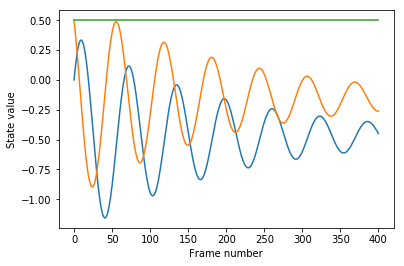

In [313]:
plt.plot(X[0,:].T)
plt.plot(X[1,:].T)
plt.plot(X[2,:].T)

plt.xlabel('Frame number')
plt.ylabel('State value')

# Make snapshots with noise

In [314]:
X1 = X[:,0:-1] + np.matrix([np.random.normal(0, 0.02, iterations)]*3)
X2 = X[:,1:] + np.matrix([np.random.normal(0, 0.02, iterations)]*3)

# Naive reconstruction through pseudo inverse

In [315]:
A_pinv = X2*np.linalg.pinv(X1)

In [316]:
A_pinv

matrix([[ 9.98118787e-01,  8.05229078e-02,  1.74603876e-02],
        [-9.89603521e-02,  9.64844527e-01, -1.07560096e-01],
        [-7.96321857e-04, -1.78719193e-02,  9.89309922e-01]])

In [317]:
# reconstruct timeseries

X = X1[:,0]

iterations = 400
for i in range(iterations):
    xnew = A_pinv*X[:, -1]
    X = np.hstack((X, xnew))

Text(0,0.5,'State value')

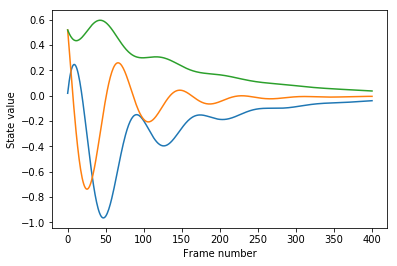

In [318]:
plt.plot(X[0,:].T)
plt.plot(X[1,:].T)
plt.plot(X[2,:].T)

plt.xlabel('Frame number')
plt.ylabel('State value')

# Naive reconstruction using CVX 

(Essentially the same as the pseudo inverse)

In [370]:
# Set up the variables
A = cvxpy.Variable((X.shape[0], X.shape[0]))

# Define the objective function
L1 = cvxpy.sum_squares(X2 - (A@X1)) # X2 = A X1, this constraint is "the data"
obj = cvxpy.Minimize(L1) 

# Set up problem
prob = cvxpy.Problem(obj)

# Solve problem
prob.solve(solver='MOSEK')

# Pull out A
A_cvx_naive = np.matrix(A.value)

In [371]:
A_cvx_naive

matrix([[ 9.98118780e-01,  8.05229072e-02,  1.74603875e-02],
        [-9.89603513e-02,  9.64844520e-01, -1.07560095e-01],
        [-7.96321851e-04, -1.78719192e-02,  9.89309915e-01]])

In [372]:
# reconstruct timeseries

X = X1[:,0]

iterations = 400
for i in range(iterations):
    xnew = A_cvx_naive*X[:, -1]
    X = np.hstack((X, xnew))

Text(0,0.5,'State value')

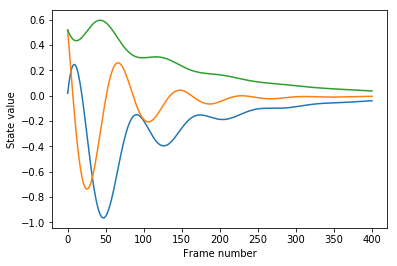

In [373]:
plt.plot(X[0,:].T)
plt.plot(X[1,:].T)
plt.plot(X[2,:].T)

plt.xlabel('Frame number')
plt.ylabel('State value')

# First informed reconstruction of A

Suppose we know the last row.

In [374]:
# Set up the variables
A = cvxpy.Variable((X.shape[0], X.shape[0]))

# Define the objective function
L1 = cvxpy.sum_squares(X2 - (A@X1)) # X2 = A X1, this constraint is "the data"
obj = cvxpy.Minimize(L1) 

In [376]:
# Create some constraints: for each element that is known, constrain the value by some epsilon

A_known = np.matrix([[np.nan, np.nan, np.nan],
                     [np.nan, np.nan, np.nan],
                     [0, 0, 1]])

epsilon = 1e-8
constraints = []
if A_known is not None:
    for i in range(A_known.shape[0]):
        for j in range(A_known.shape[1]):
            if not np.isnan(A_known[i,j]):
                constraint_lo = A[i,j] >= A_known[i,j]-epsilon
                constraint_hi = A[i,j] <= A_known[i,j]+epsilon 
                constraints.extend([constraint_lo, constraint_hi])

In [329]:
# Solve the problem
prob = cvxpy.Problem(obj, constraints)
prob.solve(solver='MOSEK') 

A_cvx_inf1 = np.matrix(A.value)
A_cvx_inf1

matrix([[ 9.98118776e-01,  8.05229069e-02,  1.74603874e-02],
        [-9.89603509e-02,  9.64844516e-01, -1.07560095e-01],
        [ 5.87195201e-09, -1.42747865e-08,  9.99999975e-01]])

In [330]:
X = X1[:,0]

iterations = 400
for i in range(iterations):
    xnew = A_cvx_inf1*X[:, -1]
    X = np.hstack((X, xnew))

Text(0,0.5,'State value')

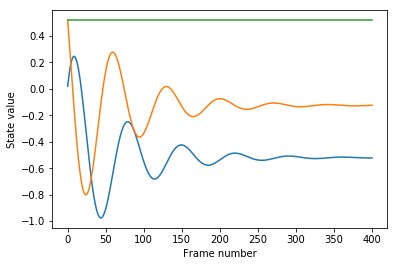

In [331]:
plt.plot(X[0,:].T)
plt.plot(X[1,:].T)
plt.plot(X[2,:].T)

plt.xlabel('Frame number')
plt.ylabel('State value')

# Second informed reconstruction

Suppose we also know that A[1,0] and A[0,1] are equal but opposite sign, that is, A[0:2, 0:2].

In [382]:
# Set up the variables
A = cvxpy.Variable((X.shape[0], X.shape[0]))

# Define the objective function
L1 = cvxpy.sum_squares(X2 - (A@X1)) # X2 = A X1, this constraint is "the data"
obj = cvxpy.Minimize(L1) 

In [383]:
A_known = np.matrix([[np.nan, np.nan, np.nan],
                     [np.nan, np.nan, np.nan],
                     [0, 0, 1]])

epsilon = 1e-8
constraints = []
# constraints
if A_known is not None:
    for i in range(A_known.shape[0]):
        for j in range(A_known.shape[1]):
            if not np.isnan(A_known[i,j]):
                constraint_lo = A[i,j] >= A_known[i,j]-epsilon
                constraint_hi = A[i,j] <= A_known[i,j]+epsilon 
                constraints.extend([constraint_lo, constraint_hi])
                
constraint_lo = A[0,1] + A[1,0] <= epsilon
constraint_hi = A[0,1] + A[1,0] >= -epsilon
constraints.extend([constraint_lo, constraint_hi])


# Solve the problem
prob = cvxpy.Problem(obj, constraints)
prob.solve(solver='MOSEK') 

A_cvx_inf2 = np.matrix(A.value)
A_cvx_inf2

matrix([[ 9.98626819e-01,  9.01076478e-02,  2.09507428e-02],
        [-9.01076583e-02,  9.65352560e-01, -9.95000715e-02],
        [ 6.20642469e-09, -1.58063007e-08,  9.99999972e-01]])

In [384]:
X = X1[:,0]

iterations = 400
for i in range(iterations):
    xnew = A_cvx_inf2*X[:, -1]
    X = np.hstack((X, xnew))

Text(0,0.5,'State value')

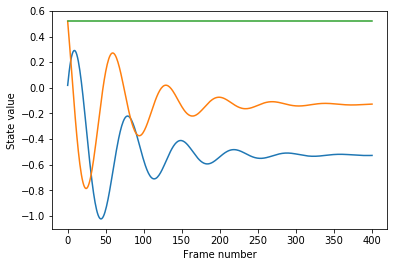

In [385]:
plt.plot(X[0,:].T)
plt.plot(X[1,:].T)
plt.plot(X[2,:].T)

plt.xlabel('Frame number')
plt.ylabel('State value')

# Third informed reconstruction

Suppose we also know the system is very unstable. That means that for this discrete system the sum of the eigenvalues should be close to 3, since anything over three means that at least one eigenvalue is > 1, which for the discrete system is unstable.

The sum of the eigenvalues is equal to the trace of the matrix, so we can constrain the trace to be large. However, we cannot maximize the trace, because that is not convex. 

This is, kind of, cheating, because really we don't know the trace, but it is a demo that might be useful.

In [389]:
# Set up the variables
A = cvxpy.Variable((X.shape[0], X.shape[0]))

# Define the objective function
L1 = cvxpy.sum_squares(X2 - (A@X1)) # X2 = A X1, this constraint is "the data"
obj = cvxpy.Minimize(L1) 

In [390]:
A_known = np.matrix([[np.nan, np.nan, np.nan],
                     [np.nan, np.nan, np.nan],
                     [0, 0, 1]])

epsilon = 1e-8
constraints = []
# constraints
if A_known is not None:
    for i in range(A_known.shape[0]):
        for j in range(A_known.shape[1]):
            if not np.isnan(A_known[i,j]):
                constraint_lo = A[i,j] >= A_known[i,j]-epsilon
                constraint_hi = A[i,j] <= A_known[i,j]+epsilon 
                constraints.extend([constraint_lo, constraint_hi])
                
constraint_lo = A[0,1] + A[1,0] <= epsilon
constraint_hi = A[0,1] + A[1,0] >= -epsilon
constraints.extend([constraint_lo, constraint_hi])

# add the trace constraint
constraints.extend([cvxpy.trace(A)>=2.98])


# Solve the problem
prob = cvxpy.Problem(obj, constraints)
prob.solve(solver='MOSEK') 

A_cvx_inf3 = np.matrix(A.value)
A_cvx_inf3

matrix([[ 1.00631811e+00,  9.00900692e-02,  2.78079208e-02],
        [-9.00900752e-02,  9.73681873e-01, -9.68451414e-02],
        [ 3.10991415e-09, -8.51157187e-09,  9.99999983e-01]])

In [391]:
X = X1[:,0]

iterations = 400
for i in range(iterations):
    xnew = A_cvx_inf3*X[:, -1]
    X = np.hstack((X, xnew))

Text(0,0.5,'State value')

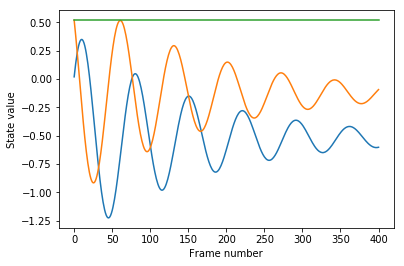

In [392]:
plt.plot(X[0,:].T)
plt.plot(X[1,:].T)
plt.plot(X[2,:].T)

plt.xlabel('Frame number')
plt.ylabel('State value')